# Libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Parameters

In [ ]:
N = 1_000_000       # Total Population
D = 5.0            # Infection duration (days)
gamma = 1.0 / D     # Recovery rate
delta = 1.0 / 5.0   # Incubation rate (1/5 days)
rho = 1/9           # Rate from infection to death (1/9 days)
alpha = 0.05        # Death rate
R_0_start, k, x0, R_0_end = 5.0, 0.5, 50, 0.5
v01 = 30             # Beginning of vaccination (phase 1)
v02 = 30             # Beginning of vaccination (phase 2)

def beta(t):
    r0_t = (R_0_start - R_0_end) / (1 + np.exp(-k * (-t + x0))) + R_0_end
    return r0_t * gamma
def heaviside(t, start_day):
    return 1.0 if t >= start_day else 0.0

# No Vaccination (Lockdown at t=50)

In [28]:
def deriv_phase0(y, t, N, gamma, delta, rho, alpha):
    S, E, I, R, D_comp = y
    
    # Phase 1 Parameters
    dSdt = -beta(t) * I / N * S 
    dEdt = beta(t) * I / N * S - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    
    return dSdt, dEdt, dIdt, dRdt, dDdt

## Plotting

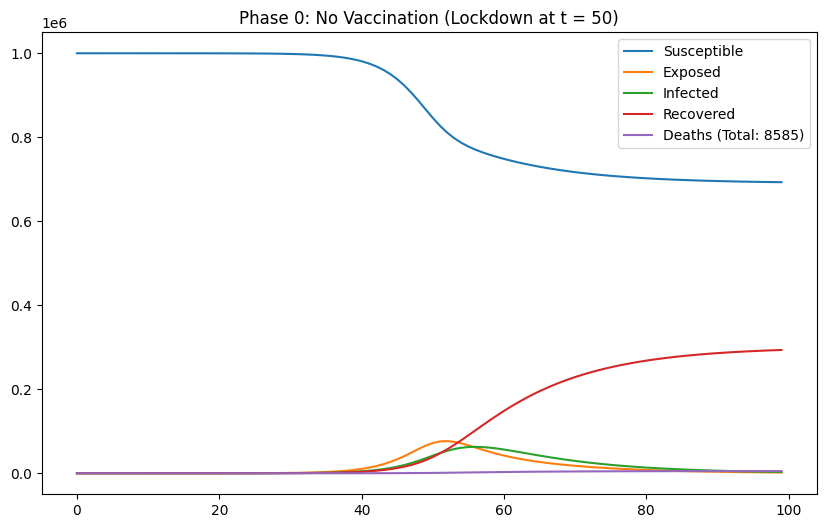

<Figure size 640x480 with 0 Axes>

In [29]:
t = np.linspace(0, 99, 100)
y0_phase0 = (N-1, 1, 0, 0, 0)
ret = odeint(deriv_phase0, y0_phase0, t, args=(N, gamma, delta, rho, alpha))
S, E, I, R, D_final0 = ret.T
total_deaths_0 = int(D_final0[-1])

plt.figure(figsize=(10,6))
plt.plot(t, S, label="Susceptible")
plt.plot(t, E, label="Exposed")
plt.plot(t, I, label="Infected")
plt.plot(t, R, label="Recovered")
plt.plot(t, D_final, label=f"Deaths (Total: {total_deaths_0})")
plt.legend()
plt.title("Phase 0: No Vaccination (Lockdown at t = "+str(x0)+str(")"))
plt.show()
plt.savefig("No Vaccination x0="+str(x0))

# Single Dose with 100% immunity

In [30]:
def deriv_phase1(y, t, N, gamma, delta, rho, alpha):
    S, E, I, R, D_comp, V = y
    
    # Phase 1 Parameters
    vac_rate = 0.01   # vaccination rate
    vac_start = v01    # Starting day of vaccination
    vaccination_flow = vac_rate * S * heaviside(t, vac_start)   # No of individuals vaccinated in each day
    
    dSdt = -beta(t) * I / N * S - vaccination_flow
    dEdt = beta(t) * I / N * S - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    dVdt = vaccination_flow 
    
    return dSdt, dEdt, dIdt, dRdt, dDdt, dVdt

In [11]:
## Plotting

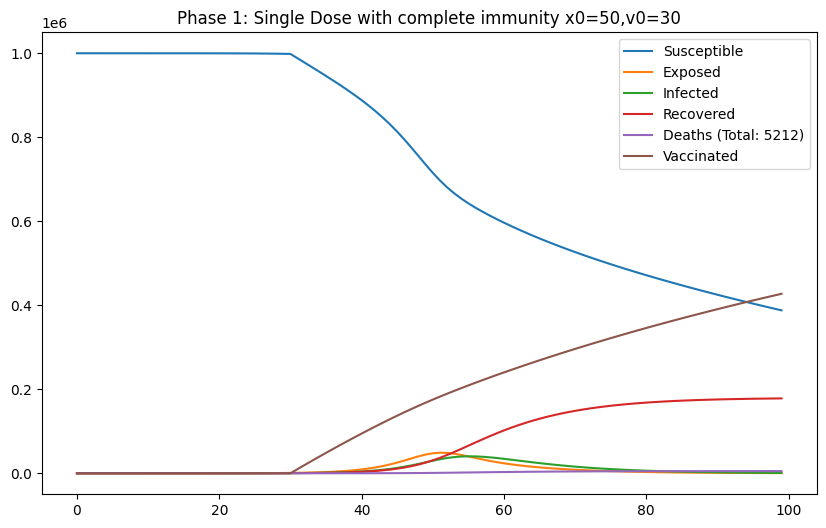

<Figure size 640x480 with 0 Axes>

In [31]:
t = np.linspace(0, 99, 100)
y0_phase1 = (N-1, 1, 0, 0, 0, 0)
ret = odeint(deriv_phase1, y0_phase1, t, args=(N, gamma, delta, rho, alpha))
S, E, I, R, D_final1, V = ret.T
total_deaths_1 = int(D_final1[-1])

plt.figure(figsize=(10,6))
plt.plot(t, S, label="Susceptible")
plt.plot(t, E, label="Exposed")
plt.plot(t, I, label="Infected")
plt.plot(t, R, label="Recovered")
plt.plot(t, D_final, label=f"Deaths (Total: {total_deaths_1})")
plt.plot(t, V, label="Vaccinated")
plt.legend()
plt.title("Phase 1: Single Dose with complete immunity x0="+str(x0)+",v0="+str(v01))
plt.show()
plt.savefig("Single Dose x0="+str(x0)+"_v0="+str(v01))

# Comparing deaths with and without vaccination

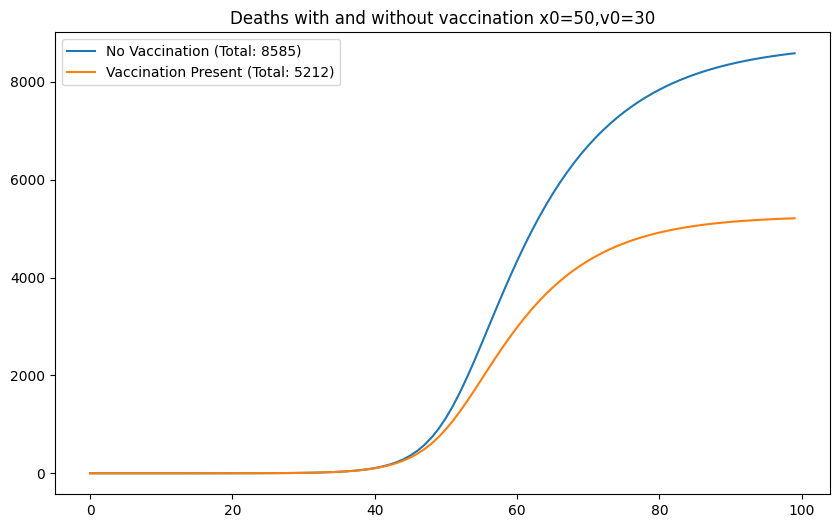

<Figure size 640x480 with 0 Axes>

In [32]:

plt.figure(figsize=(10,6))
plt.plot(t, D_final0, label=f"No Vaccination (Total: {total_deaths_0})")
plt.plot(t, D_final1, label=f"Vaccination Present (Total: {total_deaths_1})")
plt.legend()
plt.title("Deaths with and without vaccination x0="+str(x0)+",v0="+str(v01))
plt.show()
plt.savefig("Deaths with and without vaccination x0="+str(x0)+"_v0="+str(v01))

# Single Dose with waning immunity (Mutable Virus)

In [ ]:
def deriv_phase2(y, t, N, gamma, delta, rho, alpha):
    S, E, I, R, D_comp, V = y
    vac_rate = 0.01
    vac_start = v02
    
    # Waning Immunity
    if t < 50:
        efficacy = 1.00
    else:
        efficacy = max(0, 1.00 - 0.005 * (t - 50))
    
    # Flows
    vaccination_flow = vac_rate * S * heaviside(t, vac_start)
    
    # Breakthrough: V -> E (depends on 1 - efficacy)
    breakthrough_flow = beta(t) * I / N * (1 - efficacy) * V
    
    # Equations
    dSdt = -lam * S - vaccination_flow
    
    # E gains from S (unvaccinated) AND V (breakthrough)
    dEdt = lam * S + breakthrough_flow - delta * E
    
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    
    # V gains from S, loses to Infection
    dVdt = vaccination_flow - breakthrough_flow
    
    return dSdt, dEdt, dIdt, dRdt, dDdt, dVdt